In [19]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt

In [ ]:
# Define the correct Coordinate Reference Systems (CRS)
# official EPSG codes for the *geographic* versions of these datums.
# NAD83(HARN) is EPSG:4152.
# NAD83(2011) is EPSG:6318.
crs_harn = pyproj.CRS.from_epsg(4152)
crs_2011 = pyproj.CRS.from_epsg(6318)

# transformer to go from HARN to 2011
# pyproj automatically uses the best available transformation, typically NADCON grid files.
transformer = pyproj.Transformer.from_crs(crs_harn, crs_2011, always_xy=True)

# regular grid of lon/lat points over CONUS in the NAD83(HARN) datum
lon_min, lon_max = -125.0, -65.0
lat_min, lat_max = 24.0, 50.0
res = 1.0  # 1-degree resolution is sufficient for a continental view
lons_harn, lats_harn = np.meshgrid(
    np.arange(lon_min, lon_max + res, res),
    np.arange(lat_min, lat_max + res, res)
)

# Transform the HARN grid to get the coordinates of the same physical
#    locations but expressed in the NAD83(2011) datum.
lons_2011, lats_2011 = transformer.transform(lons_harn, lats_harn)

# Calculate the horizontal shift in meters
# The pyproj.Geod class calculates distances on the ellipsoid (GRS80 for NAD83).
# This is the correct way to find the distance between two lat/lon pairs.
geod = pyproj.Geod(ellps='GRS80')

# geod.inv() computes the inverse geodesic problem, returning azimuths and distance.
# We only care about the distance in meters.
_, _, distance_m = geod.inv(
    lons_harn, lats_harn,
    lons_2011, lats_2011,
)

# expect cm-level offsets
print("Meter-Scale Shifts:")
print(f"   Min shift: {np.nanmin(distance_m):.4f} m  ({np.nanmin(distance_m) * 100:.2f} cm)")
print(f"   Max shift: {np.nanmax(distance_m):.4f} m  ({np.nanmax(distance_m) * 100:.2f} cm)")
print(f"   Avg shift: {np.nanmean(distance_m):.4f} m  ({np.nanmean(distance_m) * 100:.2f} cm)")


Meter-Scale Shifts:
   Min shift: 0.0000 m  (0.00 cm)
   Max shift: 0.8487 m  (84.87 cm)
   Avg shift: 0.0493 m  (4.93 cm)


In [22]:
import geopandas as gpd
states = gpd.read_file(
    "https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/contiguous-usa.geojson"
)

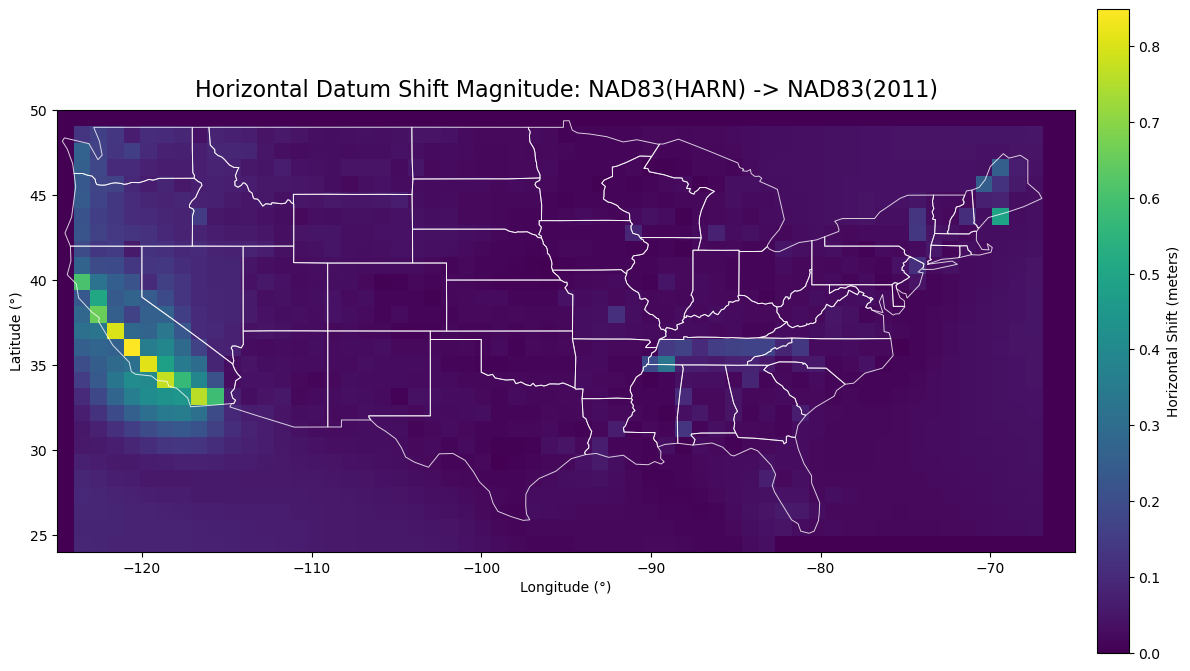

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
img = ax.imshow(
    distance_m,
    origin='lower',
    extent=(lon_min, lon_max, lat_min, lat_max),
    cmap='viridis',
    interpolation='nearest',
    zorder=1
)

states.boundary.plot(ax=ax, edgecolor='white', linewidth=0.7, alpha=0.8, zorder=2)

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_aspect('equal')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title(
    "Horizontal Datum Shift Magnitude: NAD83(HARN) -> NAD83(2011)",
    fontsize=16,
    pad=10
)

cbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.02, shrink=0.9)
cbar.set_label('Horizontal Shift (meters)')

# ax.grid(True, linestyle='--', color='black', alpha=0.2, zorder=0)

plt.tight_layout();